In [1]:
import os
import mmcv

from mmcv import Config
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import single_gpu_test
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel

import pandas as pd
import numpy as np
import json
import cv2


In [2]:
# config file 들고오기
cfg = Config.fromfile(f'/opt/ml/level2-semantic-segmentation-level2-cv-04/Swin-Transformer-Semantic-Segmentation/configs/_base_/custom/custom_config.py')


epoch = 'latest'

# dataset config 수정
# cfg.data.test.img_dir = root
# cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

# cfg.work_dir = '../output/mmseg/hr48_512x512'

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

# checkpoint path
checkpoint_path = '/opt/ml/level2-semantic-segmentation-level2-cv-04/Swin-Transformer-Semantic-Segmentation/work_dirs/custom_config/latest.pth'

In [3]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False
	)

2022-05-03 14:02:03,927 - mmseg - INFO - Loaded 624 images


In [4]:
cnt=5
for data in dataset:
	img_metas = data['img_metas'][0]
	print(img_metas)
	if cnt==0:
		break
	else:
		cnt-=1

DataContainer({'filename': '/opt/ml/input/mmseg/test/0000.jpg', 'ori_filename': '0000.jpg', 'ori_shape': (512, 512, 3), 'img_shape': (256, 256, 3), 'pad_shape': (256, 256, 3), 'scale_factor': array([0.5, 0.5, 0.5, 0.5], dtype=float32), 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([0.5, 0.5, 0.5], dtype=float32), 'std': array([0.2, 0.2, 0.2], dtype=float32), 'to_rgb': True}})
DataContainer({'filename': '/opt/ml/input/mmseg/test/0001.jpg', 'ori_filename': '0001.jpg', 'ori_shape': (512, 512, 3), 'img_shape': (256, 256, 3), 'pad_shape': (256, 256, 3), 'scale_factor': array([0.5, 0.5, 0.5, 0.5], dtype=float32), 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([0.5, 0.5, 0.5], dtype=float32), 'std': array([0.2, 0.2, 0.2], dtype=float32), 'to_rgb': True}})
DataContainer({'filename': '/opt/ml/input/mmseg/test/0002.jpg', 'ori_filename': '0002.jpg', 'ori_shape': (512, 512, 3), 'img_shape': (256, 256, 3), 'pad_shape': (256, 256, 3), 's

In [5]:
model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

load checkpoint from local path: /opt/ml/level2-semantic-segmentation-level2-cv-04/Swin-Transformer-Semantic-Segmentation/work_dirs/custom_config/latest.pth


In [6]:
output = single_gpu_test(model, data_loader)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 624/624, 1.0 task/s, elapsed: 603s, ETA:     0s

In [9]:
# sample_submisson.csv 열기
import matplotlib.pyplot as plt
import albumentations as A
submission = pd.DataFrame(columns=["image_id","PredictionString"])
json_dir = os.path.join("/opt/ml/input/data/test.json")
with open(json_dir, "r", encoding="utf8") as outfile:
    datas = json.load(outfile)

input_size = 512
output_size = 256
bin_size = input_size // output_size
size = 256
transform = A.Compose([A.Resize(size, size)])

# PredictionString 대입
cnt=20
for image_id, predict in enumerate(output):
	# if cnt==0:
	# 	break
	# else:
	# 	cnt-=1
	image_id = datas["images"][image_id]
	file_name = image_id["file_name"]

	
	# print(file_name)
	img = cv2.imread('/opt/ml/input/data/'+f'{file_name}')
	transformed = transform(image = img, mask = predict)
	
	mask = transformed['mask']
	string=mask.reshape((256 * 256)).astype(int)
	# fig=plt.figure()
	# ax = fig.add_subplot(121)
	# plt.imshow(transformed['mask'])		
	# ax = fig.add_subplot(122)
	# plt.imshow(transformed['image'])
	# plt.show()

	submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
									ignore_index=True)

# submission.csv로 저장
submission.to_csv(os.path.join(f'submission_{epoch}.csv'), index=False)

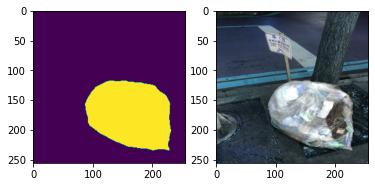

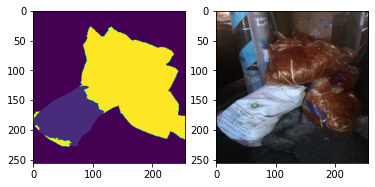

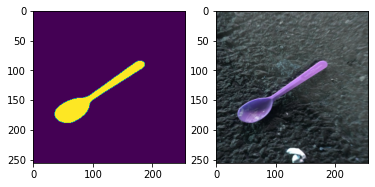

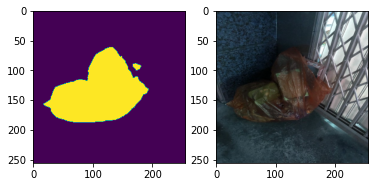

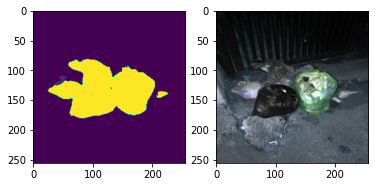

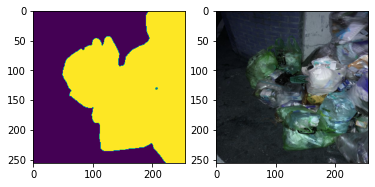

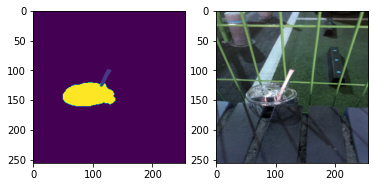

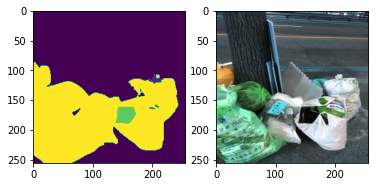

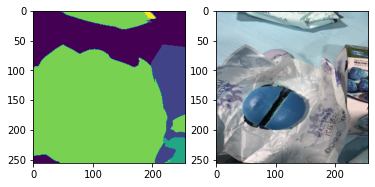

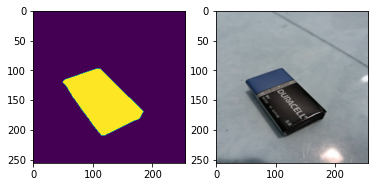

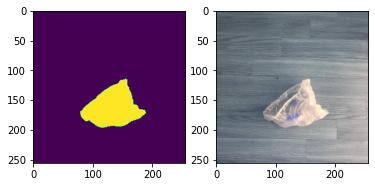

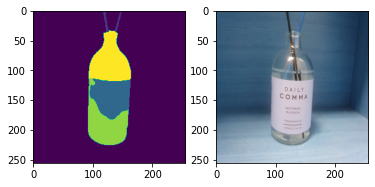

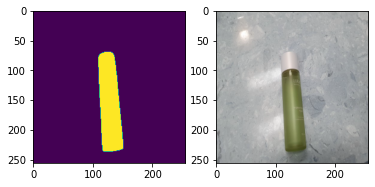

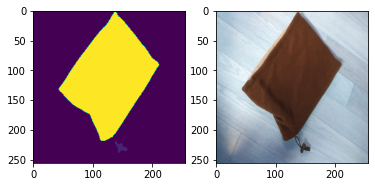

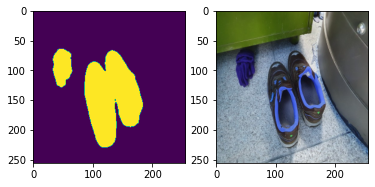

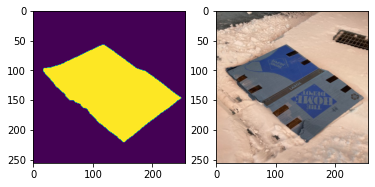

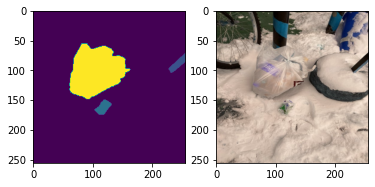

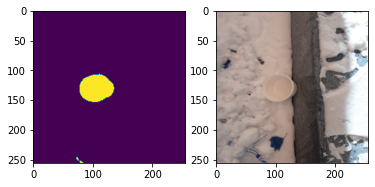

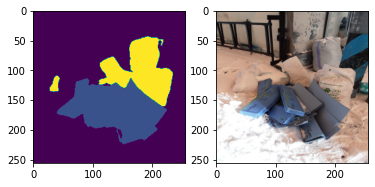

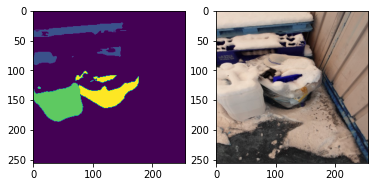

In [10]:
# sample_submisson.csv 열기
import matplotlib.pyplot as plt
import albumentations as A
submission = pd.DataFrame(columns=["image_id","PredictionString"])
json_dir = os.path.join("/opt/ml/input/data/test.json")
with open(json_dir, "r", encoding="utf8") as outfile:
    datas = json.load(outfile)

input_size = 512
output_size = 256
bin_size = input_size // output_size
size = 256
transform = A.Compose([A.Resize(size, size)])

# PredictionString 대입
cnt=20
for image_id, predict in enumerate(output):
	if cnt==0:
		break
	else:
		cnt-=1
	image_id = datas["images"][image_id]
	file_name = image_id["file_name"]

	
	# print(file_name)
	img = cv2.imread('/opt/ml/input/data/'+f'{file_name}')
	transformed = transform(image = img, mask = predict)
	
	mask = transformed['mask']
	string=mask.reshape((256 * 256)).astype(int)
	fig=plt.figure()
	ax = fig.add_subplot(121)
	plt.imshow(transformed['mask'])		
	ax = fig.add_subplot(122)
	plt.imshow(transformed['image'])
	plt.show()

# 	submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
# 									ignore_index=True)

# # submission.csv로 저장
# submission.to_csv(os.path.join(f'submission_{epoch}.csv'), index=False)

In [ ]:
# reference : https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image
input_size = 512
output_size = 256
bin_size = input_size // output_size

for image_id, predict in enumerate(output):
  temp_mask = []
  predict = predict.reshape(1, 512, 512)
  print(predict.shape)
  mask = predict.reshape((1, output_size, bin_size, output_size, bin_size)).max(4).max(2)
  print(mask.shape)
  temp_mask.append(mask)
  
  oms = np.array(temp_mask)
  oms = oms.reshape([oms.shape[0], output_size*output_size]).astype(int)
  print(oms.shape)
  predict = oms
  print(predict.shape)

(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
(1, 512, 512)
(1, 256, 256)
(1, 65536)
(1, 65536)
